In [319]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter


Second-quantized Electronic Structure:

Dihydrogen Molecule (Molecular Orbital Basis):

In [91]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()
print(diHydro_prob)


In [92]:
# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
[[-1.25633907e+00 -1.37083854e-17]
 [-6.07732712e-17 -4.71896007e-01]]
 "++--":
[[[[6.75710155e-01 1.69253442e-16]
   [1.56722377e-16 1.80931200e-01]]

  [[4.84650299e-17 1.80931200e-01]
   [6.64581730e-01 3.79897400e-16]]]


 [[[1.01440795e-16 6.64581730e-01]
   [1.80931200e-01 4.71502663e-17]]

  [[1.80931200e-01 3.78920172e-16]
   [6.59828421e-17 6.98573723e-01]]]]


In [93]:
# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op()
print(sq_h2_op)
#print("\n")
#print(diHydro_prob.basis)
#print(diHydro_prob.num_particles)

# This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211568 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211568 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211565 * ( +_1 +_1 -_0 -_0 )
+ 0.3492868613660089 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211565 * ( +_1 +_3 -_2 -_0 )
+ 0.3492868613660089 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211568 * ( +_2 +_0 -_1 -_3 )
+ 0.0904655

In [94]:
'''
Approach:

1. Employ the BogoliubovTransform method to obtain a new set of fermionic operators
that exhibit raising/lowering, as in the second quantization format.
2. Following conversion to Plane-wave basis, convert all Hamiltonian summands to Plane-wave dual basis.
3. Upon obtaining the Plane-wave dual basis, apply a Jordan-Wigner mapping to convert the Hamiltonian from
Fermionic space to a valid qubit space for manipulation purposes.
4. Apply general product formula to the converted Electronic Hamiltonian and 

Alternative Approach: No Plane-wave conversion is necessary.

1. Apply Jordan-Wigner mapping to second-quantized electronic structure, taking care of the individual summand terms so as to properly exponetiate 
the operators according to the generalized product formula.
* Do this via the following manner:

    - Obtain the complete summation of the (T + U) term (i.e., Kinetic and Attraction operators), deriving a representative unitary operator from its first-body integral coefficient.
    - Obtain the complete summation of the (V) term (i.e., Repulsive/electron-electron operators) through the second-body coefficient and associated ladder operators.

* If there exists no method to obtain a concrete decoposition of the energy operators within the Electronic Structure format, then simply convert to 
the qubit space via the Jordan-Wigner Transformation/Mapper and attempt the following:

    - Use class decomposition methods to obtain the appropriate Hamiltonian operator summands in a palatable/clean format.
    - If no such method is found, employ a Shannon Unitary Decomposition algorithm to obtain approximate summands and employ within product formula.

2. Implement the generalized product formula presented within 'A Theory of Trotter Error':
* Keep in mind the following parameters prior to implementing the decomposition:

    - Stage is arbitrary, but influences the efficiency/error bound of the algorithm; it can be set to 1 if need be for the purposes of correctness over efficiency.
    - Take the exponentiation of the individual Pauli strings, along with their associated coefficients. These will act as your "decomposed" operators.
    - 


Prerequisities:

1. Must generate appropriate code for Fermionic Fast Fourier Transform, using the Wiebe paper as a base.
    - Not a necessarily a requirement for properly converting Hamiltonian into palatable format for circuit modeling.
    - Attempt to simply convert all operators to Plane-wave dual basis first; worry about everything else later.

'''
'''
Time Evolution Approach:

1. Obtain the PauliEvolutionGate equivalent to all Pauli Strings derived from the transformation of the Second Quantized Electronic Hamiltonian into the Qubit Space.
2. Utilizing composition techiques, obtain an efficient composition of all unitary evolution operators derived from the PauliEvolutionGate components.
3. 

'''

'\nTime Evolution Approach:\n\n1. Obtain the PauliEvolutionGate equivalent to all Pauli Strings derived from the transformation of the Second Quantized Electronic Hamiltonian into the Qubit Space.\n2. Utilizing composition techiques, obtain an efficient composition of all unitary evolution operators derived from the PauliEvolutionGate components.\n3. \n\n'

In [95]:
# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)
print(qubit_h2_Ham)
#print(qubit_h2_Ham[0])

-0.8105479805373275 * IIII
+ 0.1721839326191556 * IIIZ
- 0.2257534922240239 * IIZI
+ 0.17218393261915554 * IZII
- 0.2257534922240239 * ZIII
+ 0.12091263261776629 * IIZZ
+ 0.16892753870087907 * IZIZ
+ 0.04523279994605784 * YYYY
+ 0.04523279994605784 * XXYY
+ 0.04523279994605784 * YYXX
+ 0.04523279994605784 * XXXX
+ 0.16614543256382414 * ZIIZ
+ 0.16614543256382414 * IZZI
+ 0.17464343068300445 * ZIZI
+ 0.12091263261776629 * ZZII


In [96]:
'''
# Place each Pauli String into a list for ease of exponentiation/formula ordering:

from qiskit.quantum_info import PauliList, Pauli, SparsePauliOp
#from qiskit.opflow.primitive_ops.

h2_Pauli_str = qubit_h2_Ham.primitive_strings()
print(h2_Pauli_str)
'''

'\n# Place each Pauli String into a list for ease of exponentiation/formula ordering:\n\nfrom qiskit.quantum_info import PauliList, Pauli, SparsePauliOp\n#from qiskit.opflow.primitive_ops.\n\nh2_Pauli_str = qubit_h2_Ham.primitive_strings()\nprint(h2_Pauli_str)\n'

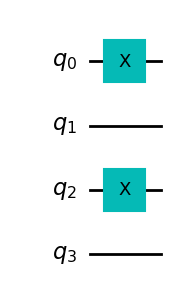

In [97]:
# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

initial_state = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

initial_state.draw('mpl')

In [98]:
# Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

#evo_summand = list() # List of PauliEvolutionGate objects
#target_time = 1.0 # Target time of real-time evolution.

#for i in range(0, len(qubit_h2_Ham)):
#    evo_summand.append(PauliEvolutionGate(qubit_h2_Ham[i]))


In [324]:
# Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

exp_summand = list()
Qubit_Ham_Op = list()
evo_time = Parameter('t')

for i in range(0, len(qubit_h2_Ham)):
    exp_summand.append((evo_time*qubit_h2_Ham[i]).exp_i()) # Append summand to exp_summand
    #print(exp_summand[i])
    #Qubit_Ham_Op.append(PauliEvolutionGate(exp_summand[i], time=))
    #Qubit_Ham_Op.append(exp_summand[i].to_circuit()) # Convert summand to valid QuantumCircuit object and append to Qubit_Ham_Op

#for i in range(0, len(qubit_h2_Ham)):
#    Qubit_Ham_Op.append(Quantumhamiltonian())
#h2_Pauli_List = SparsePauliOp.to_list(exp_summand)
#Qubit_Ham_Op[0].draw()
#print(Qubit_Ham_Op[0].width()) # Check the appropriate 
#print(Qubit_Ham_Op)
#Qubit_Ham_Op[0].draw('mpl')

#Qubit_Ham_Op[0].decompose().draw('mpl')

print(exp_summand)



[EvolvedOp(PauliSumOp(SparsePauliOp(['IIII'],
              coeffs=[-0.81054798+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['IIIZ'],
              coeffs=[0.17218393+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['IIZI'],
              coeffs=[-0.22575349+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['IZII'],
              coeffs=[0.17218393+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['ZIII'],
              coeffs=[-0.22575349+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['IIZZ'],
              coeffs=[0.12091263+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['IZIZ'],
              coeffs=[0.16892754+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['YYYY'],
              coeffs=[0.0452328+0.j]), coeff=1.0*t), coeff=1.0), EvolvedOp(PauliSumOp(SparsePauliOp(['XXYY'],
              coeffs=[0.0452328+0.j]), coeff=1.0*t), coeff=1.0),

In [100]:
# Generate valid Quantum Circuit representative of Generalized Product Formula structure:

for i in range(0, len(Qubit_Ham_Op) - 1):
    Qubit_Ham_Op[i+1] = Qubit_Ham_Op[i].compose(Qubit_Ham_Op[i+1])

Product_Formula_Circ = Qubit_Ham_Op[len(Qubit_Ham_Op) - 1]

#Qubit_Ham_Op.draw('mpl')
#Qubit_Ham_Op[14].draw()


In [101]:
# Append Classical Register to Product Formula circuit:

#class_reg = ClassicalRegister(Product_Formula_Circ.width())

#Product_Formula_Circ.add_register(class_reg)

# (Optional) Visualize constructed Product Formula circuit:

#Product_Formula_Circ.draw('mpl')


In [102]:
# Invoke simulator to compile the circuit:

backend = Aer.get_backend('aer_simulator')

circ = transpile(Product_Formula_Circ, backend)

In [103]:
# Convert constructed Product Formula circuit to operator for the purposes of algorithmic manipulation via eigensolver:

Product_Formula_Op = Operator.from_circuit(Product_Formula_Circ)
print(Product_Formula_Op)
#Product_Formula_Op.draw()

Operator([[ 1.00000000e+00-1.12264296e-14j,
           -9.85527120e-16+1.77508051e-17j,
            1.28253682e-16-2.25209995e-15j,
           -2.31343311e-15+1.57009246e-16j,
           -9.81307787e-16+7.26167762e-16j,
           -1.50871222e-15-3.81444498e-16j,
            1.70696790e-15-9.57567359e-16j,
           -2.00186788e-15+2.19812944e-15j,
           -8.32667268e-16+4.05231404e-15j,
           -1.07552856e-16-1.00613962e-16j,
           -7.84687592e-17+2.37268878e-18j,
            8.54998766e-17+8.92487770e-17j,
            7.85046229e-17-3.14018492e-16j,
            1.25998185e-16-5.43990575e-17j,
            1.25730060e-16+7.05314972e-17j,
            1.17756934e-16-7.85046229e-17j],
          [ 7.98152876e-16+3.65648532e-16j,
            3.09300384e-01+9.50964391e-01j,
           -6.17703819e-16-1.45887419e-15j,
           -1.56335845e-15-1.05229520e-15j,
           -2.17197763e-16+1.15800609e-16j,
            1.41308321e-15+2.96845605e-16j,
            3.46944695e-16-1.30

In [292]:
# Invoke SciPyRealEvolver algorithm to simulate Real Time Evolution for Dihydrogen molecule using a Generalized Product Formula method:

Time = 150 # Configure desired time for evolution.

evolution_problem = TimeEvolutionProblem(qubit_h2_Ham, Time, initial_state, aux_operators = [qubit_h2_Ham, Pauli("YYXX"), Pauli("YYYY"), Pauli("IIII")])
#evolution_problem = TimeEvolutionProblem(Product_Formula_Op, Time, initial_state, aux_operators = )

rt_evolver = SciPyRealEvolver(10) # Time Steps employed specified within argument of SciPyRealEvolver().

# Perform Real Time Evolution for time specified and product formula employed:

result = rt_evolver.evolve(evolution_problem)

print(result.observables)


[(array([-1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j,
       -1.83696799+0.j, -1.83696799+0.j, -1.83696799+0.j]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), (array([ 0.        +0.j, -0.04372484+0.j, -0.15721042+0.j, -0.29454595+0.j,
       -0.40017214+0.j, -0.43135773+0.j, -0.37548656+0.j, -0.25516138+0.j,
       -0.11905995+0.j, -0.02224231+0.j, -0.00387619+0.j]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), (array([ 0.        +0.j, -0.04372484+0.j, -0.15721042+0.j, -0.29454595+0.j,
       -0.40017214+0.j, -0.43135773+0.j, -0.37548656+0.j, -0.25516138+0.j,
       -0.11905995+0.j, -0.02224231+0.j, -0.00387619+0.j]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), (array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
       1.+0.j, 1.+0.j, 1.+0.j]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))]


In [293]:
# Inspect the associated attributes of the Real Time Evolution:

#from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver

result.evolved_state.draw('latex')

#me = MinimumEigensolver()

#print(MinimumEigensolver.compute_minimum_eigenvalue(Product_Formula_Op))


<IPython.core.display.Latex object>

Dihydrogen Electronic Hamiltonian - Evolution Attributes:

Text(0.5, 1.0, 'Energy of Dihydrogen over Trotterization Evolution')

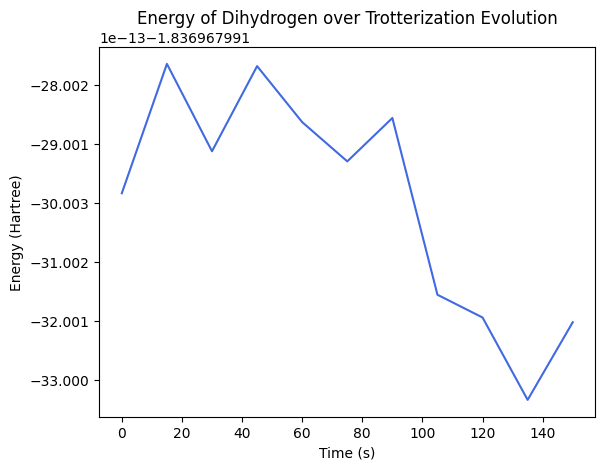

In [297]:
# Graph the energy variation over the specified time interval:

energies = np.real(result.observables)[:, 0]

plt.plot(result.times, energies[0], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Energy of Dihydrogen over Trotterization Evolution")

Built-in Trotterization Demonstration (TrotterQRTE):

In [317]:
# Comparison with built-in Trotter Evolution methods:

from qiskit.synthesis import LieTrotter

LieTrot = LieTrotter(3, 4, "chain")

LieTrotter_Op = LieTrot.synthesize(PauliEvolutionGate(qubit_h2_Ham))

#example_Ham = PauliSumOp(SparsePauliOp([Pauli("XXXX"), Pauli("YXYX")]))


#Trotter_op = Operator.from_circuit(qubit_h2_Ham.exp_i().to_circuit())

trotter_evo_prob = TimeEvolutionProblem(qubit_h2_Ham, 4, initial_state, aux_operators= [qubit_h2_Ham])
# LieTrotter with 1 rep:
estimator = Estimator()
trotter_qrte = TrotterQRTE(LieTrot, estimator, 2)
trotter_qrte_result = trotter_qrte.evolve(trotter_evo_prob)

evolved_trotter = trotter_qrte_result.evolved_state
evolved_estimator = trotter_qrte_result.aux_ops_evaluated
#evolved_trotter.decompose().draw('mpl')
#print(trotter_qrte.supports_aux_operators())
print(trotter_qrte_result.observables)
print("\n")
print(trotter_qrte_result.times)
print(evolved_estimator)

result = estimator.run([evolved_trotter], [qubit_h2_Ham[0]]).result()

print(result.values[0])

[[(-1.8369679912029837, {})], [(-1.8238109696861526, {})], [(-1.8318794612858875, {})]]


None
[(-1.8318794612858875, {})]
-0.8105479805373147


[[(-1.8369679912029837, {})], [(-1.8238109696861526, {})], [(-1.8318794612858875, {})]]


ValueError: x, y, and format string must not be None

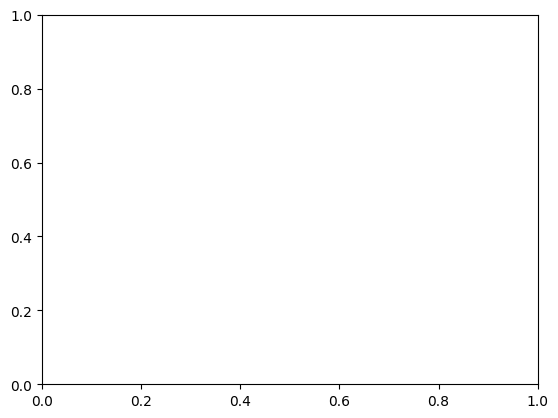

In [315]:
print(trotter_qrte_result.observables)

trotter_energies = np.real(trotter_qrte_result.observables)[:, 0]

plt.plot(trotter_qrte_result.times, trotter_energies[0], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Energy of Dihydrogen over Trotterization Evolution")


In [ ]:
# Comparison with 

In [ ]:
'''# Invoke estimator component of a Variational Quantum Eigensolver method:

estimator = Estimator()

# Invoke SLSQP optimizer component of Variational Quantum Eigensolver method:

optimizer = SLSQP(maxiter=1000)

# Invoke appropriate ansatz for Variational Quantum Eigensolver method:

ansatz = TwoLocal(4, "ry", "cz")

# Invoke compiled VQE object:

vqe = VQE(estimator, ansatz, optimizer)'''

'# Invoke estimator component of a Variational Quantum Eigensolver method:\n\nestimator = Estimator()\n\n# Invoke SLSQP optimizer component of Variational Quantum Eigensolver method:\n\noptimizer = SLSQP(maxiter=1000)\n\n# Invoke appropriate ansatz for Variational Quantum Eigensolver method:\n\nansatz = TwoLocal(4, "ry", "cz")\n\n# Invoke compiled VQE object:\n\nvqe = VQE(estimator, ansatz, optimizer)'

In [ ]:
#ansatz.draw()

In [ ]:
# Compute the minimum eigenvalue/ground state energy using the VQE method "comput_minimum_eigenvalue":

#result = vqe.compute_minimum_eigenvalue(Product_Formula_Op)
#print(result)
#result_qubit_h2_Ham = vqe.compute_minimum_eigenvalue(qubit_h2_Ham)
#print(result_qubit_h2_Ham)